# HOW TO MAKE PEOPLE FEEL REALLY DUMB WHEN THEY PLAY WITH YOU AT *7 WONDERS* ? 

**Authors** : Nycia PRADEL & Lucile LAPRAY

**Date** : 04/2/2024

## 1. Library import

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# for data modelling
from pandas.api.types import CategoricalDtype
from statsmodels.miscmodels.ordinal_model import OrderedModel
import scipy.stats as stats 
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import researchpy as rp

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 2. Data import

In [2]:
df = pd.read_csv("7wonders_games_merged.csv", delimiter = ';')
display(df)

,Dataset origin,id_Game,Extensions,Mode,Number of players,id_Player,Winner_looser,Score,Wonder,Treasury,Military,Civilian,Commercial,Guilds,Scientific,Cities,Leaders
0,online dataset,0,No,Day,4,4,1,51,3,6,18,9,8,7,0,0,0
1,online dataset,0,No,Day,4,0,1,50,10,1,-5,32,0,8,4,0,0
2,online dataset,0,No,Day,4,4,2,55,15,5,16,0,3,0,16,0,0
3,online dataset,0,No,Day,4,0,0,33,3,0,-5,4,0,0,31,0,0
4,online dataset,1,No,Day,3,5,1,50,10,4,-3,24,3,8,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,hand reported games_1,230,No,Day,7,E,1,50,8,10,4,17,10,0,1,0,0
905,hand reported games_1,230,No,Day,7,F,2,57,10,7,6,15,8,11,0,0,0
906,hand reported games_1,230,No,Day,7,L,1,45,10,2,6,19,3,5,0,0,0
907,hand reported games_1,230,No,Day,7,C,1,50,10,8,1,13,4,14,0,0,0


This dataset is the combination of three sources into a merged dataset : 1 dataset found online and 2 datasets created by hand-reporting data from the scorecards of two boxes of 7 Wonders (Pradel and Lapray families).

## 3. Data manipulation

In [3]:
# Removing of all games played with an extension (5 out of 225 games)

df_filtre = df[df['Extensions'] == 'No'].copy()

In [4]:
# Creation of a new column named Gap Strength

# It measures the distances of each categorical score to the total score
df_filtre.loc[:, 'Gap_strength'] = (abs((df_filtre['Score']/7) - df_filtre['Wonder']) \
                                + abs((df_filtre['Score']/7) - df_filtre['Treasury']) \
                                + abs((df_filtre['Score']/7) - df_filtre['Military']) \
                                + abs((df_filtre['Score']/7) - df_filtre['Civilian']) \
                                + abs((df_filtre['Score']/7) - df_filtre['Commercial']) \
                                + abs((df_filtre['Score']/7) - df_filtre['Guilds']) \
                                + abs((df_filtre['Score']/7) - df_filtre['Scientific']))/7

In [5]:
# Creation of a new column that identifies notable strategies (among 4 strategies)

strategies = ["Military", "Guilds", "Civilian", "Scientific"]
values_strat = [13, 16, 22, 23]

def strategy(row):
    strategy = []
    for i, value in zip(strategies, values_strat):
        if row[i] >= value:
            strategy.append(i)
        else:
            strategy.append('')
    return strategy

# Application of the function to each line
df_filtre['Strategy'] = df_filtre.apply(strategy, axis=1)
print(df_filtre['Strategy'])

0        [Military, , , ]
1        [, , Civilian, ]
2        [Military, , , ]
3      [, , , Scientific]
4        [, , Civilian, ]
              ...        
904              [, , , ]
905              [, , , ]
906              [, , , ]
907              [, , , ]
908    [, , , Scientific]
Name: Strategy, Length: 889, dtype: object


In [6]:
# Creation of a new complementary dataset about the strategies used by players

def extract_strategy(strategies):
    extracted_strategies = []
    for strategy_list in strategies:
        extracted_strategies.extend(strategy_list.split())
    return extracted_strategies

donnees_strategies_scores_separees = []
for index, row in df_filtre.iterrows():
    strategies = extract_strategy(row['Strategy'])
    for strat in strategies:
        donnees_strategies_scores_separees.append({'Winner_looser': row['Winner_looser'], 'Strategy': strat, 'Score': row['Score']})

df_strategies_scores_separees = pd.DataFrame(donnees_strategies_scores_separees)
df_strategies = pd.DataFrame(donnees_strategies_scores_separees)
df_strategies.rename(columns={'Winner_looser': 'Winner'}, inplace=True)
display(df_strategies)

,Winner,Strategy,Score
0,1,Military,51
1,1,Civilian,50
2,2,Military,55
3,0,Scientific,33
4,1,Civilian,50
...,...,...,...
482,1,Military,44
483,2,Military,58
484,1,Civilian,48
485,1,Civilian,47


In [7]:
# Transformation of 'Winner_looser' column into a categorical variable

categories = [0, 1, 2]
df_filtre['Winner_looser'] = pd.Categorical(df_filtre['Winner_looser'], categories = [0, 1, 2], ordered = True)
print(df_filtre['Winner_looser'].dtype)

category


## 4. Data description

In [8]:
# Definition of colors and labels used for victory depiction

colors = ['gold', 'darkorange', 'firebrick']
colors_dict = {0: 'gold', 1: 'darkorange', 2 : 'firebrick'}
ordre_victory = ['Looser', 'Mid', 'Winner']
victory_dict = {0: 'Looser', 1: 'Mid', 2 : 'Winner'}

c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=Fa

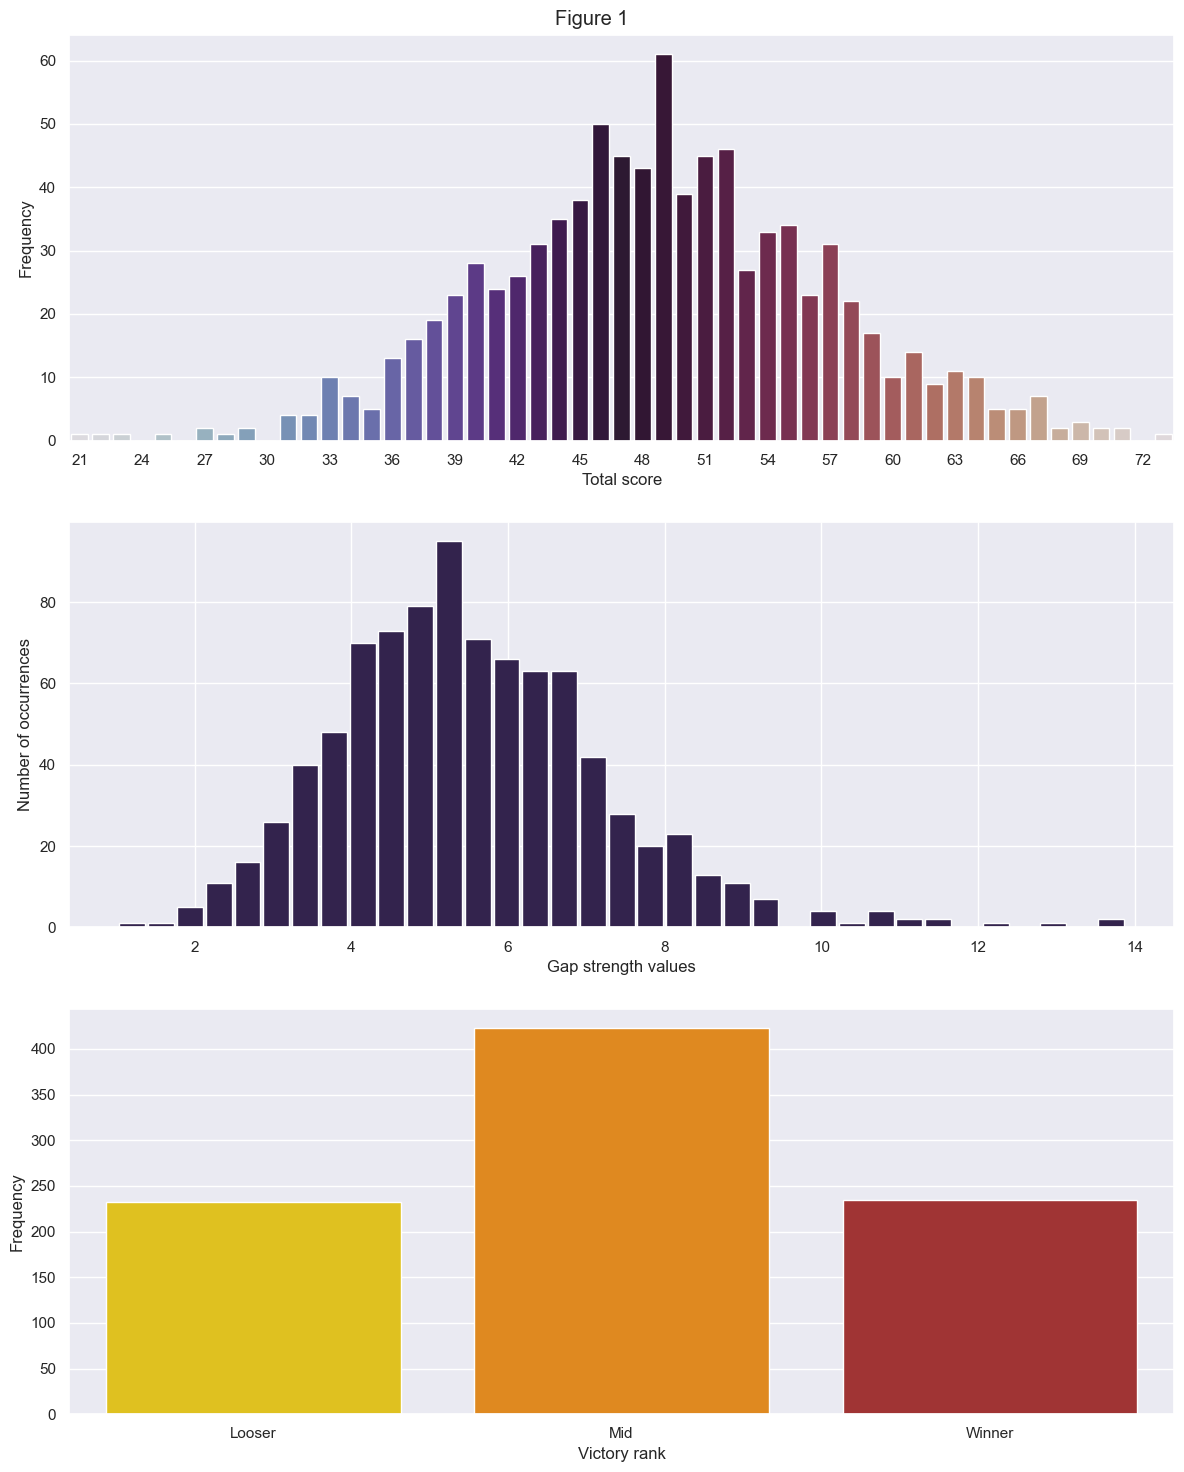

In [9]:
# Multiplot of description of data for the first part of the problematic : score, gap strength and victory rank
sns.set(style = 'darkgrid')
fig1 = plt.figure(figsize = (12, 15))
fig1.suptitle("Figure 1")

order_score = list(range(df_filtre['Score'].min(), df_filtre['Score'].max() + 1))
indices_xticks = list(range(0, len(order_score),3))


# Figure 1.a : Distribution of scores
plt.subplot(3, 1, 1)
sns.countplot(x = df_filtre['Score'], palette = 'twilight', order = order_score)
plt.xticks(ticks = indices_xticks, labels = [order_score[i] for i in indices_xticks])
plt.xlabel('Total score')
plt.ylabel('Frequency')

# Figure 1.b : Distribution of extremums
plt.subplot(3, 1, 2)
plt.hist(df_filtre['Gap_strength'], bins = 35, color = '#33234d', rwidth = 0.9)
plt.xlabel("Gap strength values")
plt.ylabel("Number of occurrences")

# Figure 1.c : Distribution of victory rank
plt.subplot(3, 1, 3)
sns.countplot(x = 'Winner_looser', data = df_filtre, palette = colors)
plt.xticks(ticks = [0, 1, 2], labels = [ordre_victory[i] for i in [0, 1, 2]])
plt.xlabel('Victory rank')
plt.ylabel('Frequency')

plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
plt.savefig('7W_fig1.jpg')
plt.show()

c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


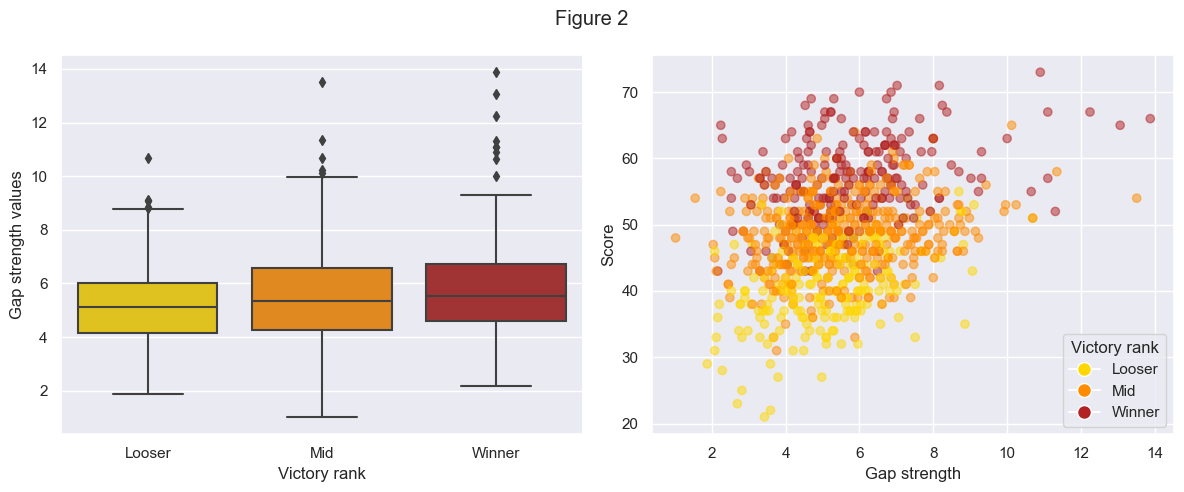

In [10]:
# Multiplot of the notion of gap strength/extremum in relation with victory rank and with score

fig2 = plt.figure(figsize = (12, 5))
fig2.suptitle('Figure 2')

# Figure 2.a : Boxplot of victory ranks depending on extremum measures
plt.subplot(1, 2, 1)
sns.boxplot(x = df_filtre['Winner_looser'], y = df_filtre['Gap_strength'], palette = colors)
plt.gca().set_xlabel("Victory rank")
plt.gca().set_ylabel("Gap strength values")
plt.xticks(ticks = [0, 1, 2], labels = [ordre_victory[i] for i in [0, 1, 2]])

# Figure 2.b : Scatter plot of extremum measures in relation with score and victory rank
plt.subplot(1, 2, 2)
plt.scatter(x = df_filtre['Gap_strength'], y = df_filtre['Score'], c = df_filtre['Winner_looser'].map(colors_dict), alpha = 0.5)
plt.xlabel('Gap strength')
plt.ylabel('Score')
legend_handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = label, markerfacecolor = colors_dict[key], markersize = 10) for key, label in victory_dict.items()]
plt.legend(handles = legend_handles, title = 'Victory rank', loc = 'best')

plt.tight_layout()
plt.savefig('7W_fig2.jpg')
plt.show()

c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

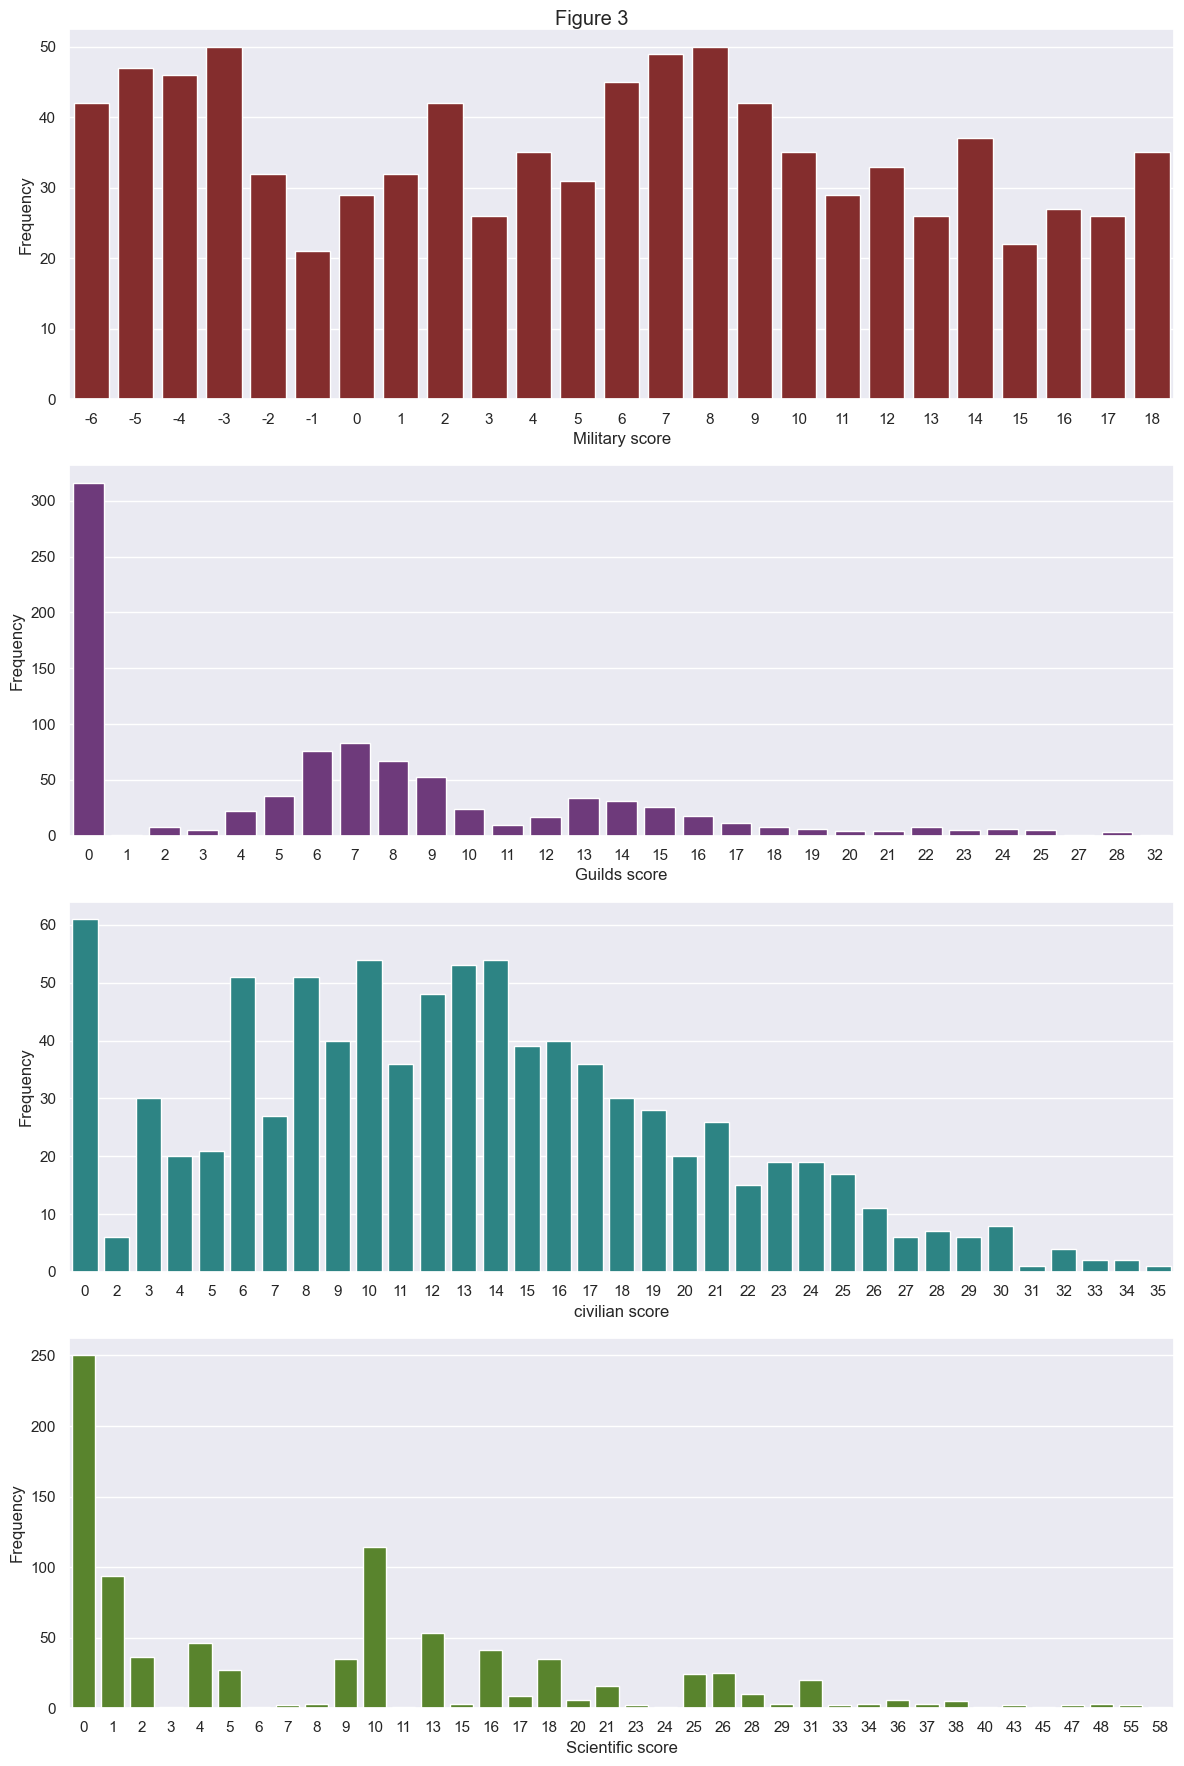

In [11]:
# Multiplot of data description for the second part of the problematic : scores of specific strategies

fig3 = plt.figure(figsize = (12, 18))
fig3.suptitle("Figure 3")

# Figure 3.a : Distribution of military score
plt.subplot(4, 1, 1)
sns.countplot(x = 'Military', data = df_filtre, color = '#931e1e')
plt.xlabel('Military score')
plt.ylabel('Frequency')

# Figure 3.b : Distribution of guild score
plt.subplot(4, 1, 2)
sns.countplot(x = 'Guilds', data = df_filtre, color = '#752f86')
plt.xlabel('Guilds score')
plt.ylabel('Frequency')

# Figure 3.c : Distribution of civil score
plt.subplot(4, 1, 3)
sns.countplot(x = 'Civilian', data = df_filtre, color = '#1e9393')
plt.xlabel('civilian score')
plt.ylabel('Frequency')

# Figure 1.c : Distribution of scientific score
plt.subplot(4, 1, 4)
sns.countplot(x = 'Scientific', data = df_filtre, color = '#59931e')
plt.xlabel('Scientific score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('7W_fig3.jpg')
plt.show()

In [2]:
#Creation of heatmaps

# Adaptation of columns to use in the heatmap and calculations for the correlation matrix
victory_columns = ['Winner_looser', 'Score', 'Gap_strength', 'Treasury', 'Military', 'Civilian', 'Scientific', 'Guilds']
df_selected = df_filtre[victory_columns]
corr = df_selected.corr()

vertical_columns = ['Winner_looser', 'Score', 'Gap_strength']
horizontal_columns = ['Treasury', 'Military', 'Civilian', 'Scientific', 'Guilds']

vert_col_2 = ['Winner_looser', 'Score']
hor_col_2 = ['Score', 'Gap_strength']

# Multiplot of heatmap to visualize correlation between the variables discussed in the problematic
fig4 = plt.figure(figsize = (12, 8))
fig4.suptitle('Figure 4')

plt.subplot(2, 1, 1)
sns.heatmap(corr.loc[vertical_columns, horizontal_columns], annot=True, cmap = 'twilight_shifted', fmt =".2f", vmin=-0.5, vmax=0.5)

plt.subplot(2, 1, 2)
sns.heatmap(corr.loc[vert_col_2, hor_col_2], annot=True, cmap = 'twilight_shifted', fmt=".2f", vmin=-1, vmax=1)

plt.tight_layout()
plt.savefig('7W_fig4.jpg')
plt.show()

NameError: name 'df_filtre' is not defined

c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lucil\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

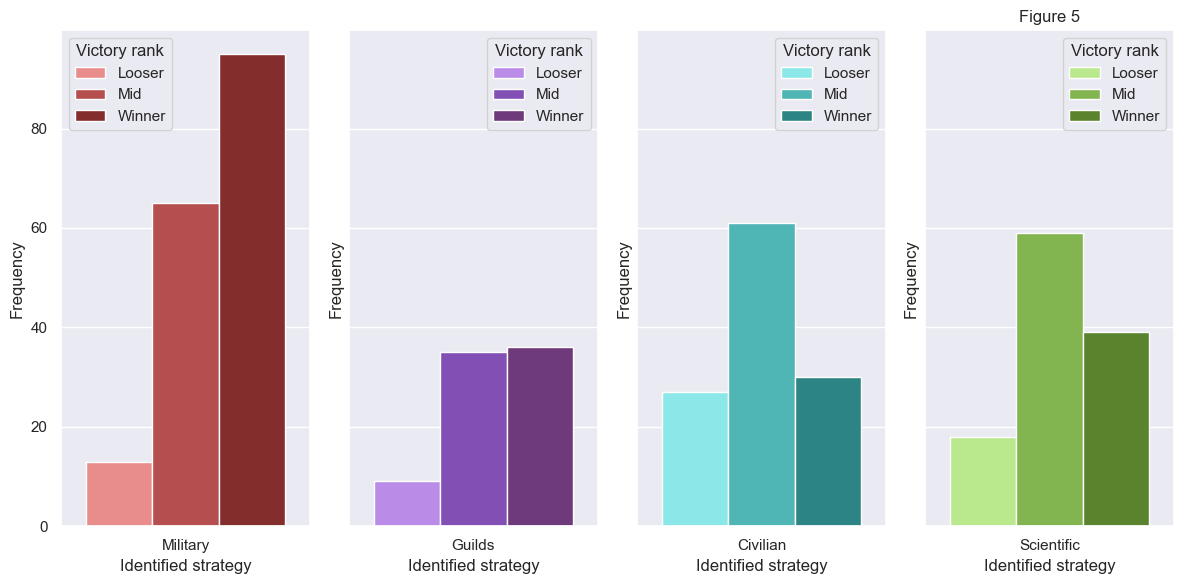

In [13]:
# Multiplot of heatmap to visualize correlation between the variables discussed in the problematic

fig5 = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

for i, (strategy, palette) in enumerate([('Military', ['#f87c7c', '#c63e3e', '#931e1e']),
                                         ('Guilds', ['#ba7cf8', '#823ec6', '#752f86']),
                                         ('Civilian', ['#7cf8f8', '#3ec6c6', '#1e9393']),
                                         ('Scientific', ['#baf87c', '#82c63e', '#59931e'])]):
    ax = plt.subplot(1, 4, i + 1)
    df_strategy = df_strategies[df_strategies['Strategy'] == strategy]
    sns.countplot(data=df_strategy, x='Strategy', hue='Winner', palette=palette)
    plt.xlabel('Identified strategy')
    plt.ylabel('Frequency')

    handles, _ = ax.get_legend_handles_labels()
    labels = [victory_dict[int(l.get_text())] for l in ax.legend().get_texts()]
    plt.legend(handles=handles, labels=labels, title='Victory rank')

plt.title('Figure 5')
plt.tight_layout()
plt.savefig('7W_fig5.jpg')
plt.show()

## 5. Data modelling

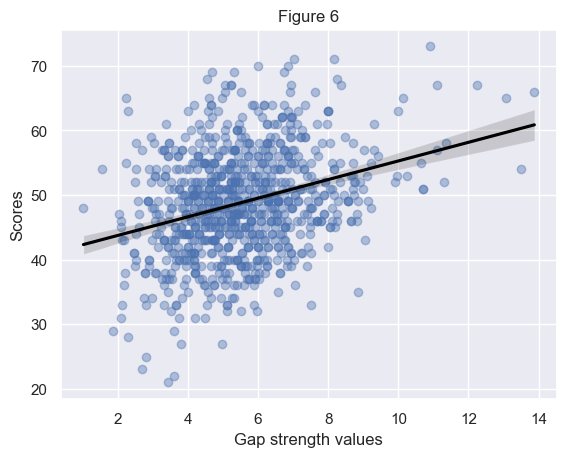

In [14]:
# Linear regression between score and gap strength
plt.title('Figure 6')

sns.regplot(x = df_filtre['Gap_strength'], y = df_filtre['Score'], line_kws = {"color": "black"}, scatter_kws = {'alpha':0.4})
plt.gca().set_xlabel("Gap strength values")
plt.gca().set_ylabel("Scores")

plt.savefig('7W_fig6.jpg')
plt.show()

In [15]:
# Simple linear regression predicting score with gap strength
model = smf.ols(formula = 'Gap_strength ~ Score', data = df_filtre).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Gap_strength   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     91.54
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           1.05e-20
Time:                        11:55:07   Log-Likelihood:                -1698.2
No. Observations:                 889   AIC:                             3400.
Df Residuals:                     887   BIC:                             3410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3354      0.336      6.960      0.000       1.677       2.994
Score          0.0649      0.007      9.568      0.000       0.052       0.078
==============================================================================
Omnibus:                       75.878   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.878
Skew:                           0.629   Prob(JB):                     6.88e-26
Kurtosis:                       4.244   Cond. No.                         303.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Multivariate ordinal regression : Victory ~ Score + Extremum 

mod_prob = OrderedModel(df_filtre['Winner_looser'], df_filtre[['Gap_strength', 'Score']], distr = 'logit')
res_log = mod_prob.fit(method = 'bfgs')
res_log.summary()

Optimization terminated successfully.
         Current function value: 0.721072
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:          Winner_looser   Log-Likelihood:                -641.03
Model:                   OrderedModel   AIC:                             1290.
Method:            Maximum Likelihood   BIC:                             1309.
Date:                Mon, 19 Aug 2024                                         
Time:                        11:55:07                                         
No. Observations:                 889                                         
Df Residuals:                     885                                         
Df Model:                           2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Gap_strength    -0.1353      0.045     -2.985      0.003      -0.224      -0.046
Score            0.2715      0.015     18.698      0.000       0.243       0.300
0/1             10.7479      0.643     16.718      0.000       9.488      12.008
1/2              1.2467      0.047     26.727      0.000       1.155       1.338
================================================================================
"""

In [17]:
# ANOVA test on the victory rank based on different strategies: 

statistique, p_value = stats.f_oneway(*[groupe['Winner_looser'] for _, groupe in df_strategies_scores_separees.groupby('Strategy')])
print("Statistique de test :", statistique)
print("Valeur p :", p_value)

rp.summary_cont(df_strategies['Winner'].groupby(df_strategies['Strategy']))

Statistique de test : 11.62560713308616
Valeur p : 2.2813440737907807e-07




,N,Mean,SD,SE,95% Conf.,Interval
Strategy,,,,,,
Civilian,118,1.0254,0.6975,0.0642,0.8983,1.1526
Guilds,80,1.3375,0.6740,0.0754,1.1875,1.4875
Military,173,1.4740,0.6340,0.0482,1.3788,1.5691
Scientific,116,1.1810,0.6801,0.0631,1.0559,1.3061
